# 0) 概論
### このNotebookでは、大まかに以下の方法で株価など時系列データの未来予測を行う
一年ほどを掛けて精度を上げていく予定。いずれは自動売買の予想モデルとして使用したい。  
2026年夏頃の完成を目指す。  
#### 論文を参考にした以下の５つのモデルでそれぞれ予測を行う  
- LSTM
- Bidirectional LSTM + Attention
- Transformer
- Informer
- Autoformer  
#### ５つのモデルの精度を考慮しつつ、結果をアンサンブルする
上記５モデルが未完成のため、現状は机上の空論のみで簡易なコードを作成。  
５モデルの出力に加えて、相関・逆相関のある金融の指数を特徴量として加える。  
アンサンブルのメタモデルには、学習性能を弱めたRandomForestを使おうと考えている。  

## 準備としてサンプルの株価を取得
Googleの株価をstooqより取得し実験

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas_datareader import data as pdr
import pandas_datareader.data as pdr
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

2025-06-22 14:32:25.622858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750602745.863429      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750602745.935296      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ticker_symbole = 'GOOG.US' 
start = '2014-01-01'
end   = datetime.now()
data = pdr.DataReader(ticker_symbole, 'stooq', start=start, end=end)

# dataには新しい順に数値が入っている 時系列にしたいので、逆順にソート
data = data.iloc[::-1]  
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-03-27,28.4000,28.4000,27.6460,27.9230,261040
2014-03-28,28.0600,28.3215,27.9335,27.9995,820060
2014-03-31,28.3445,28.3500,27.8465,27.8485,215440
2014-04-01,27.9355,28.4225,27.9355,28.3580,158640
2014-04-02,29.9995,30.2415,28.1095,28.3500,2933940


主要な指標の求め方を忘備録代わりに書いておく。  
MACDとRSIは特徴量として予測に使用する。

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


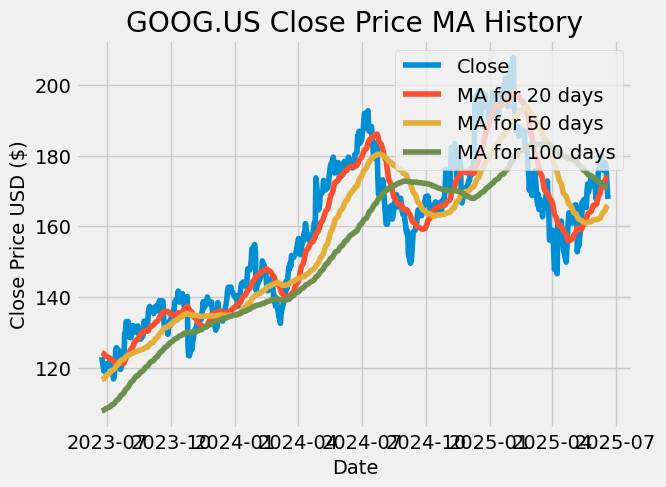

In [3]:
#-- 移動平均 --#
ma_day = [20, 50, 100]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(ma).mean()

#-- MACD --#
short_period = 12
long_period = 26
signal_period = 9
# 短期と長期のEMA（指数平滑移動平均）を計算
data['EMA_short'] = data['Close'].ewm(span=short_period, adjust=False).mean()
data['EMA_long'] = data['Close'].ewm(span=long_period, adjust=False).mean()
# MACDラインを計算
data['MACD'] = data['EMA_short'] - data['EMA_long']
# シグナルラインを計算
data['Signal'] = data['MACD'].ewm(span=signal_period, adjust=False).mean()
# MACDヒストグラムを計算
data['MACD_Histogram'] = data['MACD'] - data['Signal']

#-- RSI --#
def calc_rsi(period, delta):
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rsi = 100 *(avg_gain/(avg_gain+avg_loss))
    return rsi
delta = data['Close'].diff()
data['RSI9'] = calc_rsi(9, delta)
data['RSI14'] = calc_rsi(14, delta)

plt.title(ticker_symbole + ' Close Price MA History')
plt.plot(data['Close'][-500:])           # 最新500日のみ表示
plt.plot(data['MA for 20 days'][-500:])
plt.plot(data['MA for 50 days'][-500:])
plt.plot(data['MA for 100 days'][-500:])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days'], loc='upper right')
plt.show()

In [4]:
data.head(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Open,High,Low,Close,Volume,MA for 20 days,MA for 50 days,MA for 100 days,EMA_short,EMA_long,MACD,Signal,MACD_Histogram,RSI9,RSI14
Date,,,,,,,,,,,,,,,
2014-03-27,28.4000,28.4000,27.6460,27.9230,261040,NaN,NaN,NaN,27.923000,27.923000,0.000000,0.000000,0.000000,NaN,NaN
2014-03-28,28.0600,28.3215,27.9335,27.9995,820060,NaN,NaN,NaN,27.934769,27.928667,0.006103,0.001221,0.004882,NaN,NaN
2014-03-31,28.3445,28.3500,27.8465,27.8485,215440,NaN,NaN,NaN,27.921497,27.922728,-0.001231,0.000730,-0.001961,NaN,NaN
2014-04-01,27.9355,28.4225,27.9355,28.3580,158640,NaN,NaN,NaN,27.988651,27.954971,0.033681,0.007320,0.026360,NaN,NaN
2014-04-02,29.9995,30.2415,28.1095,28.3500,2933940,NaN,NaN,NaN,28.044243,27.984232,0.060011,0.017858,0.042153,NaN,NaN
2014-04-03,28.4925,29.3640,28.2065,28.4870,101750000,NaN,NaN,NaN,28.112360,28.021474,0.090886,0.032464,0.058422,NaN,NaN
2014-04-04,28.7325,28.8885,27.1500,27.1570,127552000,NaN,NaN,NaN,27.965381,27.957439,0.007942,0.027560,-0.019617,NaN,NaN
2014-04-07,27.0370,27.4240,26.3575,26.9075,87374340,NaN,NaN,NaN,27.802630,27.879666,-0.077035,0.006641,-0.083676,NaN,NaN
2014-04-08,27.1535,27.7500,27.0805,27.7450,62971260,NaN,NaN,NaN,27.793764,27.869691,-0.075926,-0.009873,-0.066054,47.302213,NaN


### 予測に利用するデータセットの準備
データセットに含めるのは以下の６個  
　Close（終値），Volume（出来高），MACD_Histogram，Signal，RSI9，RSI14  
Closeはリターン（変化率）に直して使用する。

In [5]:
# datasetとして利用するClose(終値)
dataset = data[['Close', 'Volume', 'MACD_Histogram', 'Signal', 'RSI9', 'RSI14']]
#-- リターン（単純変化率） --#
dataset['returns'] = dataset['Close'].pct_change()

dataset = dataset.iloc[20:]
dataset.head()

/tmp/ipykernel_13/872747020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['returns'] = dataset['Close'].pct_change()


,Close,Volume,MACD_Histogram,Signal,RSI9,RSI14,returns
Date,,,,,,,
2014-04-25,25.8090,41939940,-0.132182,-0.303998,40.836299,40.586592,-0.017100
2014-04-28,25.8575,66511300,-0.134369,-0.337591,40.113212,42.455813,0.001879
2014-04-29,26.3850,53836980,-0.091954,-0.360579,44.819820,39.772898,0.020400
2014-04-30,26.3330,34928100,-0.060579,-0.375724,27.120980,34.981568,-0.001971
2014-05-01,26.5675,38008220,-0.019348,-0.380561,45.206862,45.483628,0.008905


# 1) LSTM
過去60日分のデータを学習して61日目のデータを予想する、ということを繰り返して学習するモデル  
論文「Stock Market Prediction Using LSTM Recurrent Neural Network」に近い実装となっていそうな「mwitiderrick/stockprice」を参考  
mwitiderrick/stockprice: https://github.com/mwitiderrick/stockprice/blob/master/TATA%20.ipynb

## データの準備

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 特徴量列の選択
features = ['returns', 'Volume', 'MACD_Histogram', 'Signal', 'RSI9', 'RSI14']
feature_data = dataset[features].copy()

# スケーリング
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# StandardScaler：returns, MACD_Histogram, Signal（正負ありデータ）
standard_cols = ['returns', 'MACD_Histogram', 'Signal']
feature_data[standard_cols] = standard_scaler.fit_transform(feature_data[standard_cols])

# MinMaxScaler：Volume, RSI9, RSI14（非負データ）
minmax_cols = ['Volume', 'RSI9', 'RSI14']
feature_data[minmax_cols] = minmax_scaler.fit_transform(feature_data[minmax_cols])

#---------- トレーニングデータの作成 ----------# 
# 前から80%をトレーニングデータとして扱う
train_data_len = int(np.ceil(len(feature_data) * 0.8))
# どれくらいの期間をもとに予測するか
window_size = 60  # 60days

# 特徴量すべて（6列）をスライスし、x_train, y_trainを作成
x_train, y_train = [], []  # type: list 変換の必要あり

for i in range(window_size, train_data_len):
    x_train.append(feature_data.iloc[i - window_size:i].to_numpy())
    y_train.append(feature_data.iloc[i]['returns'])  # 目的変数は returns（正規化済）

# ndarrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)

# LSTM入力用の shape に変形
# (samples, timesteps, features)
print("x_train shape:", x_train.shape)  # → (train_samples, 60, 6)
print("y_train shape:", y_train.shape)  # → (train_samples,)

#---------- テストデータの作成 ----------#
test_data = feature_data.iloc[train_data_len - window_size:].copy()  # 60日分前から必要

x_test, y_test = [], []  # type: list 変換の必要あり

for i in range(window_size, len(test_data)):
    x_test.append(test_data.iloc[i - window_size:i].to_numpy())
    y_test.append(test_data.iloc[i]['returns'])  # 予測対象は returns（正規化済）

# ndarrayに変換
x_test, y_test = np.array(x_test), np.array(y_test)

# shape 確認（samples, timesteps, features）
print("x_test shape:", x_test.shape)   # (テストサンプル数, 60, 6)
print("y_test shape:", y_test.shape)   # (テストサンプル数,)


# 後の逆変換用に returns 専用スケーラー保存
returns_scaler = StandardScaler()
returns_scaler.fit(dataset[['returns']])  # 正規化前の 'returns' に対してフィット

x_train shape: (2185, 60, 6)
y_train shape: (2185,)
x_test shape: (561, 60, 6)
y_test shape: (561,)


StandardScaler()

## LSTMモデルの実装
４層のLSTMの間にDropout(0.2)を挟む
最適化アルゴリズムにadam、損失関数にはMSE（平均二乗誤差）を指定

In [7]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2025-06-22 14:32:44.193506: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,051 (281.45 KB)

 Trainable params: 72,051 (281.45 KB)

 Non-trainable params: 0 (0.00 B)

### モデルの学習
batch_size=32, epochs=120（データを32分割し実行、それを120回繰り返す）

In [8]:
history = model.fit(x_train, y_train, batch_size=32, epochs=120)

Epoch 1/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - loss: 1.0097
Epoch 2/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.9820
Epoch 3/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.9300
Epoch 4/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.9516
Epoch 5/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.9632
Epoch 6/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.9690
Epoch 7/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.9784
Epoch 8/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 1.0556
Epoch 9/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 1.0195
Epoch 10/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.9372
Epoch 11/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - loss: 0.9481
Epoch 12/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 1.0884
Epoch 13/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.9817
Epoch 14/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.9506
Epoch 15/120
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s

## 学習したLSTMモデルでの予測
精度確認のため、以下の指標を表示  
- 二乗平均平方根誤差RMSE
- 決定係数R2
- 的中率（誤差が指定範囲以内に収まった率）
- 方向性一致率（変化率の正負が一致した率）

In [9]:
# 予測を実行
predictions = model.predict(x_test)
predicted = returns_scaler.inverse_transform(predictions)
actual = returns_scaler.inverse_transform(y_test.reshape(-1, 1))

# 評価指標の計算
m_pred = np.mean(predicted) * 100  # %表示
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# 結果表示
print(f"平均  : {m_pred:.3f}[%]")
# print(f"MAE  : {mae:.4f}")  # 平均絶対誤差: 0に近いほど良い
print(f"RMSE : {rmse:.4f}")  # 二乗平均平方根誤差: 0に近いほど良い
print(f"R²   : {r2:.4f}")    # 決定係数: 1に近いほど良い

# 的中率（独自定義）を求める
# 閾値リスト（パーセンテージ表記）
thresholds = [0.001, 0.002, 0.005]

print("的中率（予測誤差が閾値以内）:")
for threshold in thresholds:
    errors = np.abs(predicted - actual)  # 絶対誤差を計算
    hit_mask = errors <= threshold  # 的中条件
    hit_rate = np.mean(hit_mask) * 100  # 的中率（%）を計算
    print(f"  ±{threshold*100:.1f}%以内: {hit_rate:.2f}%")

# 予測と実際の符号が一致しているか
same_direction = np.sign(predicted) == np.sign(actual)
directional_accuracy = np.mean(same_direction) * 100

print(f"方向性一致率: {directional_accuracy:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
平均  : -0.570[%]
RMSE : 0.0287
R²   : -1.3956
的中率（予測誤差が閾値以内）:
  ±0.1%以内: 5.17%
  ±0.2%以内: 8.02%
  ±0.5%以内: 17.65%
方向性一致率: 53.12%


## 30日先までをマルチステップ予測
LSTMモデルを使って 1日先→2日先→3日先…と、予測値を連鎖的に使って、30日先まで予測するマルチステップ予測（逐次予測） を行う関数を作る。  
それによって作ったグラフと実際の株価グラフを並べて表示する。  
これは無理のある予測で、間違いなく30日先では精度は低くなる。（純粋な実験）
  
まずは30日先まで予測を連鎖させる関数を作る。

In [10]:
def predict_future_sequence(model, recent_data, window_size=60, future_days=30):
    """
    model        : 学習済みのLSTMモデル（Keras）
    recent_data  : 正規化された系列データ（scaled）で、shape=(window_size, 1)
    window_size  : モデルの入力シーケンス長（通常は60）
    future_days  : 何日先まで予測するか（通常は30）
    
    戻り値: 予測値のリスト（正規化済）
    """
    predictions = []

    # 予測に使うデータをコピー（書き換えないため）
    input_seq = recent_data.copy()

    for _ in range(future_days):
        # モデルに入力するためshape変換: (1, window_size, x_train.shape[2])
        x_input = np.reshape(input_seq, (1, window_size, x_train.shape[2]))

        # 予測
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0][0])  # スカラー値として保存

        # input_seqを1つシフトして、予測値を末尾に追加
        input_seq = np.append(input_seq[1:], [[pred[0][0]]], axis=0)

    return predictions

### 30日分のマルチステップ予測

In [11]:
# 30日前からさかのぼって60日分（正規化済）のデータを準備
last_60_scaled = feature_data[["returns", "Volume", "MACD_Histogram", "Signal", "RSI9", "RSI14"]][-90:-30].to_numpy().reshape(-1, 1)  # shape=(60, 1)

# 最後の30日をマルチステップ予測
future_returns_scaled = predict_future_sequence(model, last_60_scaled, window_size=60, future_days=30)

# 逆正規化
future_returns = returns_scaler.inverse_transform(np.array(future_returns_scaled).reshape(-1, 1))

### 求まったのはリターン（変化率）なので、価格に変換する

In [12]:
# 最後の実際の価格
last_price = dataset.iloc[-31]['Close']

# リターンから株価へ変換
future_preds = [last_price]
for ret in future_returns:
    next_price = future_preds[-1] * (1 + ret[0])
    future_preds.append(next_price)

# 先頭のlast_priceだけは実際の値であることに注意

print(f"起点価格: {last_price:.2f}")
print(f"予測された価格（最初の5日）: {future_preds[:5]}")

起点価格: 152.80
予測された価格（最初の5日）: [152.8, 149.14685639441015, 150.17963383588622, 143.75613729163592, 150.58280895966985]


### 実際の株価とマルチステップ予測値をグラフで比較
実際の株価＝Val  
予測値＝Predictions

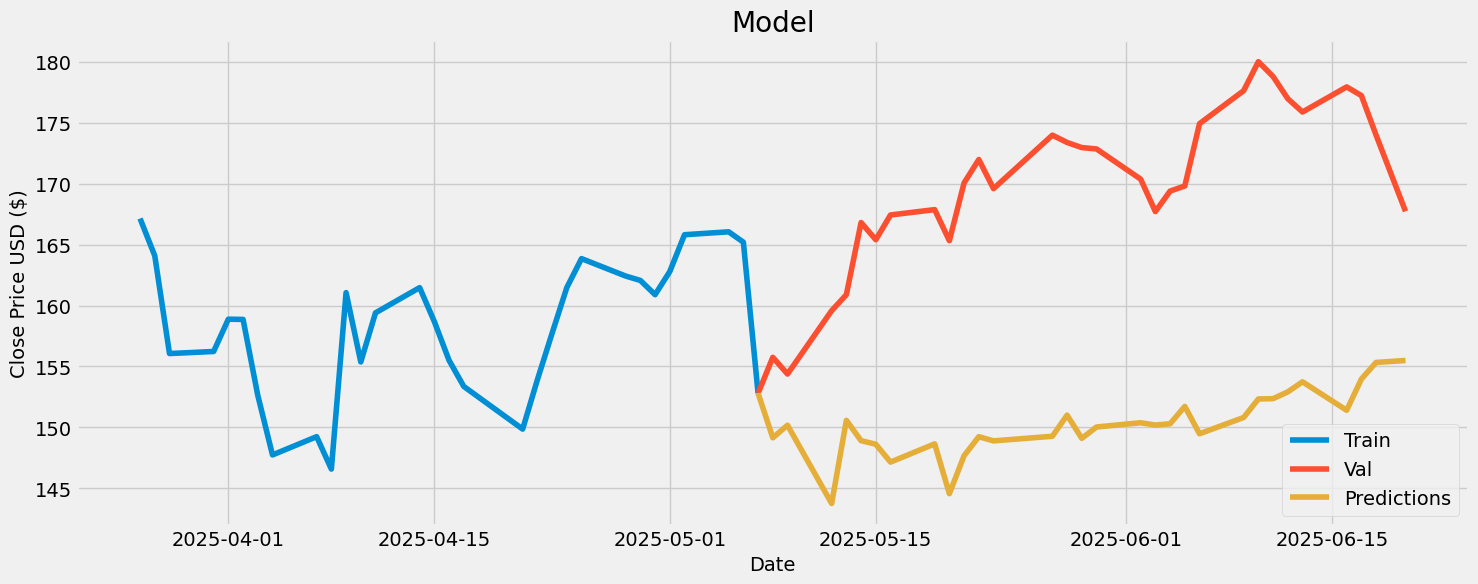

In [13]:
train = data[:-30]
valid = data[-31:].copy()  # コピーを作成 グラフをつなげるために31日前からのデータ
valid['Predictions'] = future_preds

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'][-30:], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

## --- 1) 予測結果の評価 ---  
予測変化率の平均は0.054％なので誤差0.1以内には収まってほしいものだが、ダメだった。  
方向性一致率（今回の結果53.30%）を見ると、低い数値ではあるが、この50+3.30%は投資において大きなリードとなる可能性がある。  
他のモデルを使いこれを60%まで高めたい。  
    
モデルの学習性能を上げることもそうだが、有効な特徴量を増やすことも考える必要がある。  
ディープラーニングが万能の魔法でないことが確認できただけでも前進である。

# 2) Bidirectional LSTM + Attention
#### モデル概略：  
- Bidirectional LSTM により前後のデータから推移を学習
- 複数特徴量を入力可能（例：終値、移動平均、出来高など）
- Attention機構 による重要な時点の強調
- Attentionレイヤーを可視化して「モデルがどの時点に注目して予測を行ったか」を確認可能にする
  
### Attentionの効果  
作成したAttention層は、時間軸方向の重み付けを学習し、重要なタイムステップに集中できるようになる。これはニュースやイベントなどの「特定時点の影響が強い」金融時系列に有効である。  
  
このモデルをまとめると、LSTMの強み（時系列モデリング）に加えて、Bidirectionalで双方向の文脈を考慮し、Attentionで重要タイムステップを抽出し、DropoutとDenseで汎化性能を高めたモデルである。

## データの準備  
1)LSTM で使った入力データをそのまま使う  
x_train shape: (2185, 60, 6)  
y_train shape: (2185,)  
x_test shape: (561, 60, 6)  
y_test shape: (561,)  

## Bidirectional LSTMモデルとAttentionレイヤーの実装
### Attentionレイヤーについて
LSTMやGRUの出力に使えるような自作のレイヤーであり、keras.layers.Attentionのようにクエリ（query）・キー（key）・バリュー（value）に基づくattentionを計算するものではない。  
#### < 特徴 >
- 時系列データ向けのシンプルなattention
- 各時刻ステップにスカラーの重みを付け、全体の加重平均（コンテキストベクトル）を出力
- 単方向（self-attentionではない）
- スカラー重み（1ユニット）を使ってsoft attentionを実装
- return_attention=Trueでattention weightsを出力（可視化向け）

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, BatchNormalization
import tensorflow.keras.backend as K

# Attentionレイヤー（重み出力用）
class AttentionLayer(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super().__init__(**kwargs)  # Kerasカスタムレイヤーの内部的な初期化処理を実行
        self.return_attention = return_attention  # Attentionの重み出力をするか否か

    def build(self, input_shape):  # レイヤー内部の学習可能なパラメータ（重みなど）を定義
                                   # 入力を与えると自動で実行
                                   # W（重み行列）, b（バイアス）
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),    # 特徴量の次元数（LSTMの出力次元数）
                                 initializer='glorot_uniform',  # Xavier初期化
                                 trainable=True)                # 学習対象
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),  # 時系列の長さ（タイムステップ数）
                                 initializer='zeros',        # 初期値 0
                                 trainable=True)             # 学習対象
        super().build(input_shape)

    def call(self, x):  # Kerasのカスタムレイヤーで定義するメインの処理関数
                        # __call()__に入れられ、自動で実行
        e = K.tanh(K.dot(x, self.W) + self.b)        # スコア
        a = K.softmax(e, axis=1)                     # 重み（合計1）
        output = x * a                               # 各時刻の出力に重みを乗算
        context_vector = K.sum(output, axis=1)       # 重み付き和
        if self.return_attention:
            return [context_vector, a]
        else:
            return context_vector

### Bidirectional LSTMモデルの実装
学習能力が弱かったようなので、Bidirectional LSTMの後にDense層とBatchNormalizationを追加した。

In [15]:
# モデル定義関数
def create_model_with_attention(seq_len=60, num_features=6):
    # 入力の形状（例：60タイムステップ × 特徴量数）
    inputs = Input(shape=(seq_len, num_features))
    
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)

    context_vector, attention_weights = AttentionLayer(return_attention=True)(x)

    x = Dense(128, activation='relu')(context_vector)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1)(x)  # 予測値（1日後の変化率）

    model = Model(inputs=inputs, outputs=output)
    att_model = Model(inputs=inputs, outputs=attention_weights)  # Attention可視化用モデル

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model, att_model

### モデルの学習
batch_size=16, epochs=100（データを16分割し実行、それを100回繰り返す）

In [16]:
# モデルの作成
model, att_model = create_model_with_attention()

# 学習
history = model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - loss: 2.1487
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 1.3969
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 1.2632
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 1.1749
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 1.2456
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 1.0999
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 1.0850
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 1.0611
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 1.0710
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 1.1345
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.9550
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.9433
Epoch 13/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 1.0513
Epoch 14/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.9598
Epoch 15/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - l

## 学習したBidirectional LSTMモデルでの予測 
精度確認のため、以下の指標を表示  
- 二乗平均平方根誤差RMSE
- 決定係数R2
- 的中率（誤差が指定範囲以内に収まった率）
- 方向性一致率（変化率の正負が一致した率）

In [17]:
# 予測を実行
predictions = model.predict(x_test)
predicted = returns_scaler.inverse_transform(predictions)
actual = returns_scaler.inverse_transform(y_test.reshape(-1, 1))

# 評価指標の計算
m_pred = np.mean(predicted) * 100  # %表示
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# 結果表示
print(f"平均  : {m_pred:.3f}[%]")
# print(f"MAE  : {mae:.4f}")  # 平均絶対誤差: 0に近いほど良い
print(f"RMSE : {rmse:.4f}")  # 二乗平均平方根誤差: 0に近いほど良い
print(f"R²   : {r2:.4f}")    # 決定係数: 1に近いほど良い

# 的中率（独自定義）を求める
# 閾値リスト（パーセンテージ表記）
thresholds = [0.001, 0.002, 0.005]

print("的中率（予測誤差が閾値以内）:")
for threshold in thresholds:
    errors = np.abs(predicted - actual)  # 絶対誤差を計算
    hit_mask = errors <= threshold  # 的中条件
    hit_rate = np.mean(hit_mask) * 100  # 的中率（%）を計算
    print(f"  ±{threshold*100:.1f}%以内: {hit_rate:.2f}%")

# 予測と実際の符号が一致しているか
same_direction = np.sign(predicted) == np.sign(actual)
directional_accuracy = np.mean(same_direction) * 100

print(f"方向性一致率: {directional_accuracy:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
平均  : 0.316[%]
RMSE : 0.0193
R²   : -0.0769
的中率（予測誤差が閾値以内）:
  ±0.1%以内: 6.24%
  ±0.2%以内: 11.23%
  ±0.5%以内: 26.92%
方向性一致率: 55.26%


## Attentionの可視化
特定の入力に対する注意重み（各タイムステップへの注目度）を表示

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


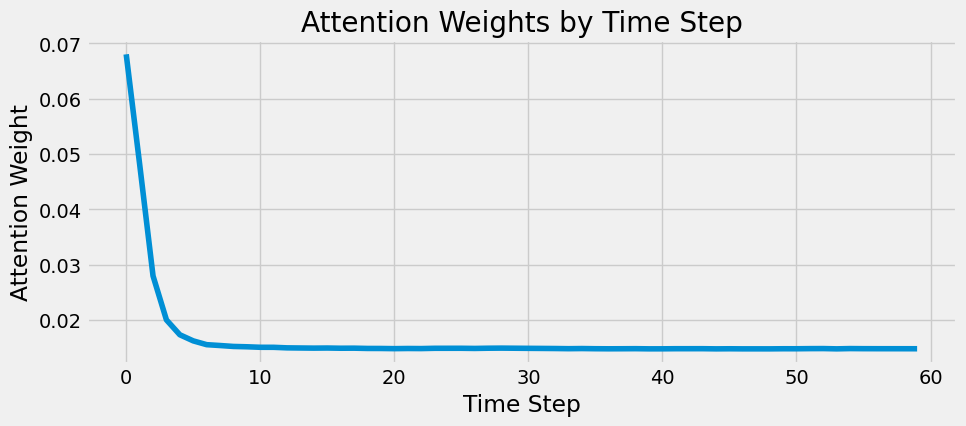

In [18]:
# X_sample: (1, 60, num_features) の1つのサンプルを渡す
day_sample = []
day_sample.append(x_test[300])
X_sample = np.array(day_sample)

attention_weights = att_model.predict(X_sample)

# 可視化
plt.figure(figsize=(10, 4))
plt.plot(attention_weights[0])
plt.title("Attention Weights by Time Step")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.show()

## 30日先までをマルチステップ予測

In [19]:
def predict_future_sequence(model, recent_data, window_size=60, future_days=30):
    """
    model        : 学習済みのLSTMモデル（Keras）
    recent_data  : 正規化された系列データ（scaled）で、shape=(window_size, 1)
    window_size  : モデルの入力シーケンス長（通常は60）
    future_days  : 何日先まで予測するか（通常は30）
    
    戻り値: 予測値のリスト（正規化済）
    """
    predictions = []

    # 予測に使うデータをコピー（書き換えないため）
    input_seq = recent_data.copy()

    for _ in range(future_days):
        # モデルに入力するためshape変換: (1, window_size, x_train.shape[2])
        x_input = np.reshape(input_seq, (1, window_size, x_train.shape[2]))

        # 予測
        pred = model.predict(x_input, verbose=0)
        predictions.append(pred[0][0])  # スカラー値として保存

        # input_seqを1つシフトして、予測値を末尾に追加
        input_seq = np.append(input_seq[1:], [[pred[0][0]]], axis=0)

    return predictions


# 30日前からさかのぼって60日分（正規化済）のデータを準備
last_60_scaled = feature_data[["returns", "Volume", "MACD_Histogram", "Signal", "RSI9", "RSI14"]][-90:-30].to_numpy().reshape(-1, 1)  # shape=(60, 1)

# 最後の30日をマルチステップ予測
future_returns_scaled = predict_future_sequence(model, last_60_scaled, window_size=60, future_days=30)

# 逆正規化
future_returns = returns_scaler.inverse_transform(np.array(future_returns_scaled).reshape(-1, 1))

# 最後の実際の価格
last_price = dataset.iloc[-31]['Close']

# リターンから株価へ変換
future_preds = [last_price]
for ret in future_returns:
    next_price = future_preds[-1] * (1 + ret[0])
    future_preds.append(next_price)

# 先頭のlast_priceだけは実際の値であることに注意

print(f"起点価格: {last_price:.2f}")
print(f"予測された価格（最初の5日）: {future_preds[:5]}")

起点価格: 152.80
予測された価格（最初の5日）: [152.8, 153.58767124898733, 154.09176580898287, 154.14014167274794, 159.93269521581954]


### 実際の株価とマルチステップ予測値をグラフで比較
実際の株価＝Val  
予測値＝Predictions

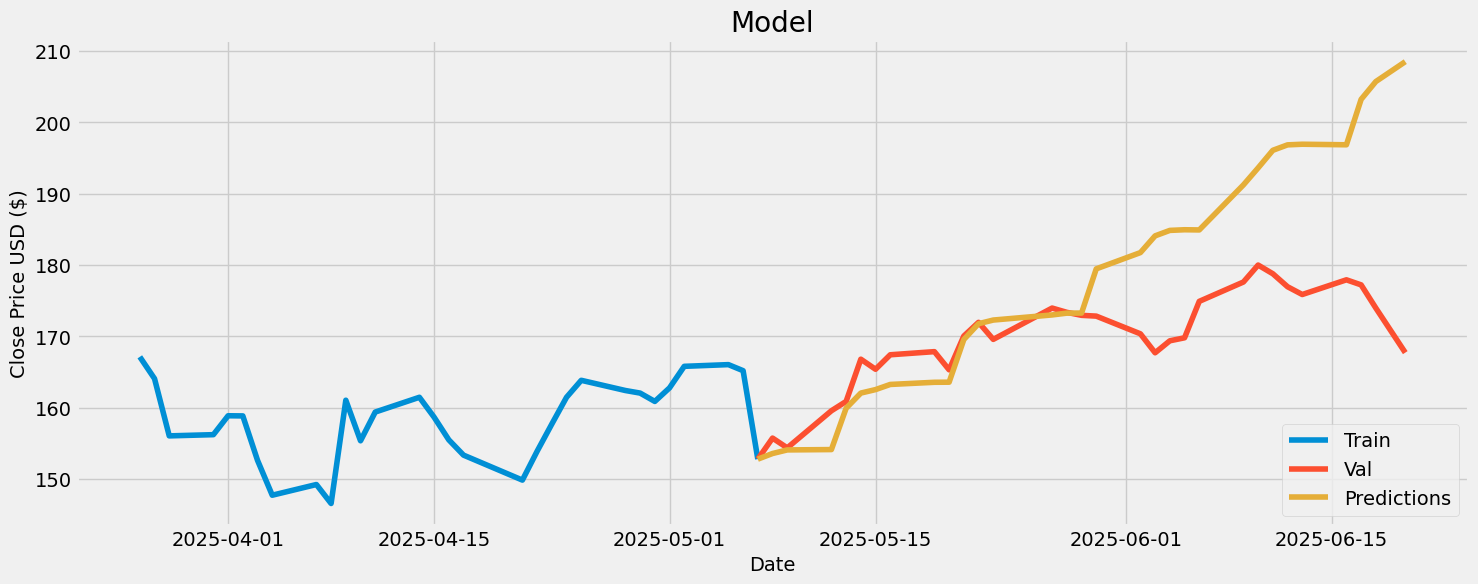

In [20]:
train = data[:-30]
valid = data[-31:].copy()  # コピーを作成 グラフをつなげるために31日前からのデータ
valid['Predictions'] = future_preds

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'][-30:], label='Train')
plt.plot(valid['Close'], label='Val')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

## --- 2) 予測結果の評価 ---  
LSTMのときとそれほど精度が上がっていない。  
lossを見ると学習がまだ完了していないように見えるが、学習が安定していない。  
  
しかし方向性一致率＝57.04%など、評価指標を見ると悪いものではなかった。  
アンサンブルの材料としては良い結果であった。

# 3) Transformer
Informerは複雑なので、学習しやすく、概念が分かりやすいTransformerベースの標準的な構成  
以下の動画を参考にした  
https://youtu.be/LNydD9ZemZ8  
### モデルの特徴
- seq_len=60：過去60日分の入力
- d_model=64：埋め込み後の次元
- Multi‑Head Attention：自己注意によって各ステップの重要な相互関係を学習
- 残差 + LayerNorm により深い学習が安定
- GlobalAveragePooling によって時系列全体から意味ある特徴を抽出

ここで Transformer, Informer, Autoformer について、特徴を比較しておく。  
  
#### モデル　　　　　入力長	　　　　特徴	　　　　　　おすすめ用途  
基本Transformer	　60〜120　　自己注意による並列処理	　中規模データ / 複数特徴量  
Informer 	　　　　96〜512　　長期依存を捉えやすい　　　長期予測 / 大規模データ  
Autoformer	　　　96〜512　　傾向と周期性の分解　　　　季節性の強い時系列に◎

In [21]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import Dense, LayerNormalization, Dropout
# from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D

# def build_transformer_model(seq_len=60, num_features=5, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
#     inputs = Input(shape=(seq_len, num_features))
#     x = Dense(d_model)(inputs)  # 埋め込み次元へ変換
    
#     # Encoder層
#     attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
#     attn_out = Dropout(dropout)(attn_out)
#     x = LayerNormalization()(x + attn_out)  # 残差接続 + 正規化
    
#     ff = Dense(ff_dim, activation="relu")(x)
#     ff = Dense(d_model)(ff)
#     ff = Dropout(dropout)(ff)
#     x = LayerNormalization()(x + ff)
    
#     x = GlobalAveragePooling1D()(x)  # 時系列平均
#     x = Dropout(dropout)(x)
#     outputs = Dense(1)(x)  # 次日株価予測
    
#     model = Model(inputs, outputs)
#     model.compile(optimizer="adam", loss="mse")
#     return model

# model = build_transformer_model(seq_len=60, num_features=5)
# model.summary()
